In [33]:
import pandas as pd
import requests
import time
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt

In [42]:
class NewsToFuturePriceMapper:
    def __init__(self, news_csv_path, verbose=False, shuffle=True, rows_limit = None):
        self.news_csv_path = news_csv_path
        self.base_url = "https://api.binance.com/api/v3"
        self.session = requests.Session()
        self.verbose = verbose
        self.shuffle = shuffle
        self.rows_limit = rows_limit
        
        self.time_intervals = {
            '1m': 1,
            '5m': 5,
            '30m': 30,
            '1h': 60,
            # '1d': 1440
        }
        
    def load_news_data(self):
        """
        Upload news data from CSV file
        """
        try:
            df = pd.read_csv(self.news_csv_path)

            assert 'date_time' in df.columns, "CSV file must contain 'date_time' column"
            assert 'title' in df.columns, "CSV file must contain 'title' column"

            df['date_time'] = pd.to_datetime(df['date_time'])

            if self.shuffle:
                df = df.drop_duplicates('date_time') # Remove duplicates by date
                df = df.sample(frac=1).reset_index(drop=True)
            
            if self.rows_limit:
                df = df.iloc[:self.rows_limit]

            if self.verbose:
                print(f"Loaded {len(df)} news articles")
                print(f'Shuffle is {self.shuffle}')
                print(f'Rows limit is {self.rows_limit != None}')
            return df
        except Exception as e:
            print(f"Failed to load: {e}")
            return None
    
    def get_kline_at_time(self, symbol, target_time, time_delta=1, interval='1m', limit=1):
        """
        Extracts price at specific time for a given symbol and interval
        
        Args:
            symbol: Ticker 
            target_time: target datetime
            time_delta: time delta to end_time in minutes
            interval: kline interval
            limit: number of klines
        """
        
        start_time = int(target_time.timestamp() * 1000)
        end_time = int((target_time + timedelta(minutes=time_delta)).timestamp() * 1000)
        
        url = f"{self.base_url}/klines"
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_time,
            'endTime': end_time,
            'limit': limit
        }
        
        try:
            response = self.session.get(url, params=params)
            response.raise_for_status()
            data = response.json()
            
            if data:
                return float(data[0][4])  # close price
            else:
                return None
                
        except requests.exceptions.RequestException as e:
            if self.verbose:
                print(f"Error for {target_time}: {e}")
            return None
    
    def get_future_prices(self, news_time, symbol='BTCUSDT'):
        """
        Extracts future prices for given time and symbol
        
        Args:
            news_time: datetime
            symbol: Ticker
        """
        future_prices = {}
        
        for interval_name, minutes in self.time_intervals.items():
            future_time = news_time + timedelta(minutes=minutes)
            
            if future_time > datetime.now():
                future_prices[f'price_after_{interval_name}'] = None
                continue
            
            price = self.get_kline_at_time(symbol, future_time)
            future_prices[f'price_after_{interval_name}'] = price
            
            if self.verbose and price:
                print(f"Price after {interval_name} for {news_time}: {price}")
            
            time.sleep(0.001)
        
        return future_prices
    
    def calculate_price_changes(self, current_price, future_price):
        """
        Calculates percentage diff for price
        """
        if future_price and current_price:
            change_percent = round(((future_price - current_price) / current_price) * 100, 2)
        else:
            change_percent = None
        
        return change_percent
    
    def get_current_price(self, news_time, symbol='BTCUSDT'):
        """
        Extracts current price for given symbol
        """
        return self.get_kline_at_time(symbol, news_time)
    
    def process_news_data(self, symbol='BTCUSDT'):
        """
        Main function for processing news data
        """
        news_df = self.load_news_data()
        if news_df is None:
            return None
        
        result_df = news_df.copy()
        
        for interval_name in self.time_intervals.keys():
            result_df[f'price_after_{interval_name}'] = None
            result_df[f'price_change_{interval_name}_percent'] = None
        
        result_df['current_price'] = None
        
        for index, row in result_df.iterrows():
            news_time = row['date_time']
            
            if self.verbose:
                print(f"\n Processing {index + 1}/{len(result_df)}: {news_time}")
                print(f"Title: {row['title'][:50]}...")
            
            current_price = self.get_current_price(news_time, symbol) # Extract current price
            result_df.at[index, 'current_price'] = current_price
            
            future_prices = self.get_future_prices(news_time, symbol)
            
            for col_name, price in future_prices.items():
                result_df.at[index, col_name] = price
            
            for interval_name in self.time_intervals.keys():
                future_price = result_df.at[index, f'price_after_{interval_name}']

                result_df.at[index, f'price_change_{interval_name}_percent'] = self.calculate_price_changes(current_price, future_price)
            
            time.sleep(0.001)
        
        return result_df
    
    def save_results(self, df, filename='news_with_future_prices.csv'):
        """
        Saves results to CSV
        """
        if df is not None:
            os.makedirs('results', exist_ok=True)
            filepath = os.path.join('results', filename)
            
            df.to_csv(filepath, index=False)
            
            if self.verbose:
                print(f"\nSaved to {filepath}")
                print(f"News processed: {len(df)}")
                
                non_null_counts = {}
                for interval_name in self.time_intervals.keys():
                    col_name = f'price_after_{interval_name}'
                    non_null_count = df[col_name].notna().sum()
                    non_null_counts[interval_name] = non_null_count
                
                print("\nStats:")
                for interval, count in non_null_counts.items():
                    print(f"{interval}: {count}/{len(df)} ({count/len(df)*100:.1f}%)")
        else:
            print("No data to save")
    
    def run(self, symbol='BTCUSDT', output_filename='news_with_future_prices.csv'):
        """
        Starts the whole process
        """
        print(f"Started for {symbol} at {datetime.now()}")
        
        result_df = self.process_news_data(symbol)
        
        self.save_results(result_df, output_filename)
        
        return result_df

if __name__ == "__main__":
    # Path to your CSV file with required columns
    news_file_path = "news.csv" # Required columns: date_time, title
    
    mapper = NewsToFuturePriceMapper(news_file_path, verbose=False, rows_limit=1000)
    
    result = mapper.run(symbol='BTCUSDT', output_filename='btc_news_with_future_prices.csv')
    
    if result is not None:
        print("\nData example:")
        print(result[['date_time', 'title', 'current_price', 'price_after_1m', 'price_change_1m_percent']].head())

Started for BTCUSDT at 2025-07-12 16:43:18.850451

Data example:
            date_time                                              title  \
0 2023-12-20 19:11:51  Immutable Hits 20-Month High as Gaming Tokens ...   
1 2024-07-09 08:30:24  Swiss Crypto Bank Amina Partners Pyth Network ...   
2 2018-07-05 17:23:20  Senior Loan ETF an Attractive Option in Rising...   
3 2024-02-20 13:19:00  4 Stocks to Watch as Bitcoin Regains $1 Trilli...   
4 2025-05-04 16:08:35  Bitcoin Price at $95,832: Are Bulls Back After...   

  current_price price_after_1m price_change_1m_percent  
0      44031.32       44058.54                    0.06  
1       57749.9       57694.01                    -0.1  
2       6563.17        6554.99                   -0.12  
3      52263.61       52312.13                    0.09  
4      95507.25       95512.05                    0.01  


In [43]:
result_data = pd.read_csv(r"C:\Users\shari\PycharmProjects\StockPrediction\newsAndPriceMapping\results\btc_news_with_future_prices.csv")
result_data.head()

,Unnamed: 0,date_time,title,article_text,price_after_1m,price_change_1m_percent,price_after_5m,price_change_5m_percent,price_after_30m,price_change_30m_percent,price_after_1h,price_change_1h_percent,current_price
0,143673,2023-12-20 19:11:51,Immutable Hits 20-Month High as Gaming Tokens ...,NaN,44058.54,0.06,44121.23,0.20,43824.32,-0.47,43546.62,-1.10,44031.32
1,153088,2024-07-09 08:30:24,Swiss Crypto Bank Amina Partners Pyth Network ...,NaN,57694.01,-0.10,57714.18,-0.06,57620.01,-0.22,57660.01,-0.16,57749.90
2,39371,2018-07-05 17:23:20,Senior Loan ETF an Attractive Option in Rising...,This article was originally published onETFTre...,6554.99,-0.12,6566.01,0.04,6557.21,-0.09,6569.66,0.10,6563.17
3,88471,2024-02-20 13:19:00,4 Stocks to Watch as Bitcoin Regains $1 Trilli...,The cryptocurrency rally has resumed after a t...,52312.13,0.09,52281.83,0.03,52706.00,0.85,52207.99,-0.11,52263.61
4,179486,2025-05-04 16:08:35,"Bitcoin Price at $95,832: Are Bulls Back After...",NaN,95512.05,0.01,95445.61,-0.06,95351.52,-0.16,95444.17,-0.07,95507.25


In [44]:
intervals = {
    '1m': 1,
    '5m': 5,
    '30m': 30,
    '1h': 60,
}

In [45]:
min_data = result_data['date_time'].min()
max_data = result_data['date_time'].max()
min_data, max_data

('2013-04-11 04:05:17', '2025-05-29 14:59:14')

MEAN -0.0030318602261048305 AND STD 0.11657649077746625
Is Enbridge Inc. a Buy in 2018?
PERCENTAGE DIFF -0.54
Ethereum co-founder Buterin donates  $600k in ETH, MKR towards India’s Covid-19 relief
PERCENTAGE DIFF -0.47
“Bitcoin Laundering” Study: Where Do Criminals Turn to Mask Illicit Cryptoassets?
PERCENTAGE DIFF -0.56
5 Things You Should Always Pay For With Cash
PERCENTAGE DIFF -0.46
South Korea Follows China By Banning ICOs
PERCENTAGE DIFF 0.48
Why MercadoLibre, Inc. Stock Popped 23% in January
PERCENTAGE DIFF 0.36
Deutsche Bank warns a 'bitcoin crash’ is among the market's most significant 2018 risks
PERCENTAGE DIFF 0.84
UPDATE 6-In a world first, El Salvador makes bitcoin legal tender
PERCENTAGE DIFF 0.64
Tesla Shares Jump By 2.6% Following A Jump In Vehicle Sales In China
PERCENTAGE DIFF -0.39
3 Top Energy Stocks to Buy Right Now
PERCENTAGE DIFF 0.44
Bakkt Nightmare: Bitcoin Plunges by More Than $1,500 to $8,000
PERCENTAGE DIFF 0.87
As the first bitcoin futures expire, price and

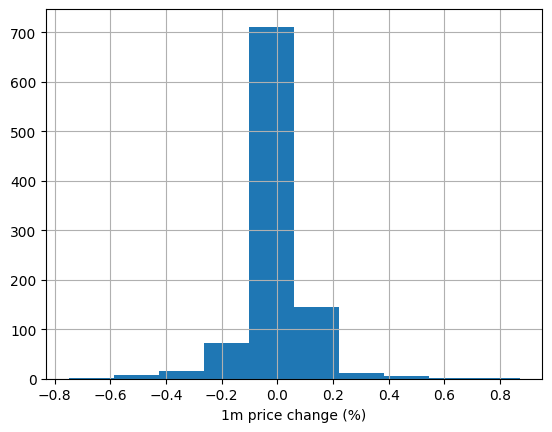

MEAN 0.007050359712230214 AND STD 0.2493333385579118
“Bitcoin Laundering” Study: Where Do Criminals Turn to Mask Illicit Cryptoassets?
PERCENTAGE DIFF -0.9
3 Upcoming Tax Changes Homeowners Need to Know About
PERCENTAGE DIFF 1.01
World's "First Social Media NFT Marketplace" Set to Hit the Market
PERCENTAGE DIFF 0.77
Bitcoin Falls to Two-Year Low as Market Reels From FTX Fallout
PERCENTAGE DIFF -0.93
Kodak is jumping on the cryptocurrency bandwagon
PERCENTAGE DIFF 0.88
Which Utility Is the Best Dividend Stock?
PERCENTAGE DIFF -0.89
Deutsche Bank warns a 'bitcoin crash’ is among the market's most significant 2018 risks
PERCENTAGE DIFF 1.21
January jobs report, Lexus teams up with Black Panther, your health care answers
PERCENTAGE DIFF 0.82
Bakkt Nightmare: Bitcoin Plunges by More Than $1,500 to $8,000
PERCENTAGE DIFF 1.63
As the first bitcoin futures expire, price and volume concerns arise
PERCENTAGE DIFF 1.19
9 Ways to Awaken Dormant Crypto Holdings
PERCENTAGE DIFF -0.76
Banks ask for s

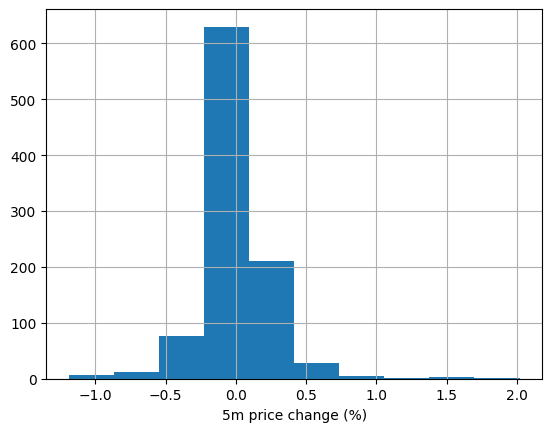

MEAN 0.018271604938271603 AND STD 0.6078075067730717
Bitcoin Tumbles From Multi-Month High on DOJ Worry, Hawkish Fed
PERCENTAGE DIFF 1.89
Is Civista (CIVB) Stock a Solid Choice Right Now?
PERCENTAGE DIFF 2.01
Top White House tech critic Tim Wu holds more than $1M in Bitcoin
PERCENTAGE DIFF -3.14
Deutsche Bank warns a 'bitcoin crash’ is among the market's most significant 2018 risks
PERCENTAGE DIFF 5.05
American Express falls despite earnings beat (AXP)
PERCENTAGE DIFF -2.03
3 Top Energy Stocks to Buy Right Now
PERCENTAGE DIFF 3.37
Bakkt Nightmare: Bitcoin Plunges by More Than $1,500 to $8,000
PERCENTAGE DIFF 2.07
As the first bitcoin futures expire, price and volume concerns arise
PERCENTAGE DIFF 2.83
El Salvador announces new purchase of 500 BTC
PERCENTAGE DIFF -2.38
Why Most Lithium Stocks Got Crushed on Thursday, With Albemarle Plunging 7.1%
PERCENTAGE DIFF -1.86
Should You Retain SBA Communications (SBAC) Stock Presently?
PERCENTAGE DIFF 2.12
Uzbekistan Wants Bitcoin Miners To Go S

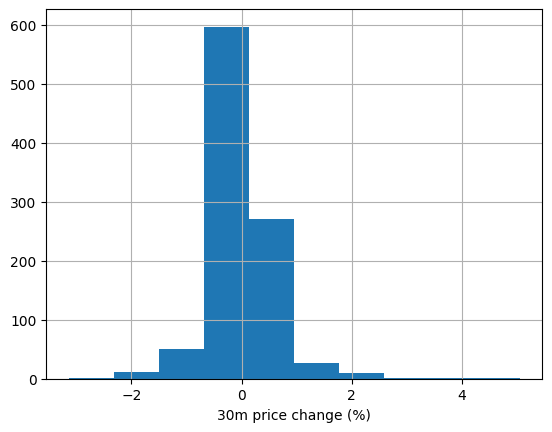

MEAN -0.006327160493827152 AND STD 0.7811527223642099
Is Civista (CIVB) Stock a Solid Choice Right Now?
PERCENTAGE DIFF 2.76
FTSE 100 Live: SEC approves Bitcoin-spot ETFs; China property risks 'crystalising' warns BoE deputy
PERCENTAGE DIFF 2.34
Ethereum  poised and ready? ETH on-chain analysis (January 2022)
PERCENTAGE DIFF -2.57
Top White House tech critic Tim Wu holds more than $1M in Bitcoin
PERCENTAGE DIFF -4.03
Here's Why You Should Consider Investing in A. O. Smith (AOS)
PERCENTAGE DIFF 2.66
Deutsche Bank warns a 'bitcoin crash’ is among the market's most significant 2018 risks
PERCENTAGE DIFF 4.07
American Express falls despite earnings beat (AXP)
PERCENTAGE DIFF -4.68
Bakkt Nightmare: Bitcoin Plunges by More Than $1,500 to $8,000
PERCENTAGE DIFF 3.74
Scaramucci Halts Withdrawals in a Fund After Stock, Crypto Swoon
PERCENTAGE DIFF 2.54
You spoke, we listened!

⭐️Restorative Rebase Upgrade Coming to τBitcoin⭐️

τBitcoin hodlers will not be impacted…
PERCENTAGE DIFF 2.64
A 2nd H

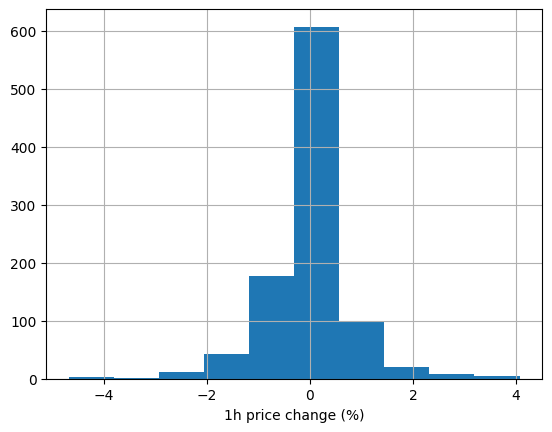

In [46]:
for interval_name, minutes in intervals.items():
    if f'price_change_{interval_name}_percent' in result_data.columns:
        result_data[f'price_change_{interval_name}_percent'].astype(float).hist()

        mean = result_data[f'price_change_{interval_name}_percent'].mean()
        std = result_data[f'price_change_{interval_name}_percent'].std()
        
        mask = abs(result_data[f'price_change_{interval_name}_percent'] - mean) > 3 * std
        print("MEAN {} AND STD {}".format(mean, std))
        if mask.any():
            for i in range(len(result_data)):
                if mask[i]:
                    print(result_data.loc[i, 'title'])
                    print(f'PERCENTAGE DIFF {result_data.loc[i, f"price_change_{interval_name}_percent"]}')

        plt.xlabel(f'{interval_name} price change (%)')
        plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binance.client import Client
from datetime import datetime, timedelta

client = Client()

symbol = 'BTCUSDT'
intervals = {
    '1m': 1,
    '5m': 5,
    '30m': 30,
    '1h': 60,
}
num_samples = 1000

plt.figure(figsize=(15, 12))

for i, (interval_name, binance_interval) in enumerate(intervals.items(), 1):
    days_back = 60 + (float(intervals[interval_name]) // (24 * 60))
    start_date = (datetime.now() - timedelta(days=days_back)).strftime('%Y-%m-%d')
    
    klines = client.get_historical_klines(
        symbol=symbol,
        interval=interval_name,
        start_str=start_date
    )
    
    columns = [
        'open_time', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_volume', 'trades',
        'taker_buy_base', 'taker_buy_quote', 'ignore'
    ]
    df = pd.DataFrame(klines, columns=columns)
    
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close'] = df['close'].astype(float)
    
    min_date = df['open_time'].min()
    max_date = df['open_time'].max()
    
    date_range = (max_date - min_date).total_seconds()
    random_seconds = np.random.uniform(0, date_range, num_samples)
    random_dates = [min_date + timedelta(seconds=s) for s in random_seconds]
    
    pct_changes = []
    interval_minutes = int(interval_name[:-1]) if interval_name.endswith('m') else 60
    
    for rd in random_dates:
        end_time = rd + timedelta(minutes=interval_minutes)
        
        start_candle = df[df['open_time'] <= rd].iloc[-1] if not df[df['open_time'] <= rd].empty else None
        end_candle = df[df['open_time'] >= end_time]
        
        if start_candle is not None and not end_candle.empty:
            end_candle = end_candle.iloc[0]
            start_price = start_candle['close']
            end_price = end_candle['close']
            pct_change = (end_price - start_price) / start_price * 100
            pct_changes.append(pct_change)
    
    plt.subplot(2, 2, i)
    plt.hist(pct_changes, bins=50, alpha=0.7, color=f'C{i}', density=True)
    plt.title(f'Распределение % изменения цены ({interval_name})')
    plt.xlabel('% Изменение цены')
    plt.ylabel('Плотность вероятности')
    plt.grid(alpha=0.3)
    
    if pct_changes:
        median = np.median(pct_changes)
        mean = np.mean(pct_changes)
        std = np.std(pct_changes)
        plt.axvline(median, color='red', linestyle='dashed', linewidth=1.5, label=f'Медиана: {median:.4f}%')
        plt.axvline(mean, color='green', linestyle='dashed', linewidth=1.5, label=f'Среднее: {mean:.4f}%')
        plt.legend()
        plt.figtext(0.15, 0.02, f"Интервал {interval_name}: Среднее = {mean:.4f}%, Медиана = {median:.4f}%, STD = {std:.4f}",
                    ha="left", fontsize=9, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

TypeError: 'int' object is not subscriptable

<Figure size 1500x1200 with 0 Axes>